#Pós PUC-Rio - Machine Learning - Aula 03

###Dataset: Pima Indians Diabetes

Este dataset é originalmente do Instituto Nacional de Diabetes e Doenças Digestivas e Renais.

Objetivo: prever se um paciente terá ou não diabetes com base em certas medidas de diagnóstico médico.

In [2]:
# Configuração para não exibir warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


##Carga do Dataset

In [5]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/tatianaesc/datascience/main/diabetes.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


##Separação em conjunto de treino e conjunto de teste com holdout

**Realizando a separação do dataset nas bases de treino e teste utilizando o método holdout**

In [18]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:8]
y = array[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

##Modelagem e Inferência

###Criação e avaliação de modelos: linha base

Iniciaremos agora a etapa de modelagem e inferência, mas não sabemos de antemão quais algoritmos performarão bem nesse conjunto de dados. Assim, usaremos a validação cruzada para treinar e avaliar os modelos usando a métrica acurácia.

Primeiramente, iremos avaliar os algoritmos com a configuração padrão de hiperparâmetros da scikit-Learn:

In [19]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

LR: 0.762427 (0.057485)
KNN: 0.711978 (0.058934)
CART: 0.702010 (0.063448)
NB: 0.746060 (0.051145)
SVM: 0.749418 (0.040958)
Bagging: 0.760814 (0.046503)
RF: 0.772263 (0.048493)
ET: 0.756002 (0.066055)
Ada: 0.749418 (0.052763)
GB: 0.750952 (0.057316)
Voting: 0.762507 (0.061246)


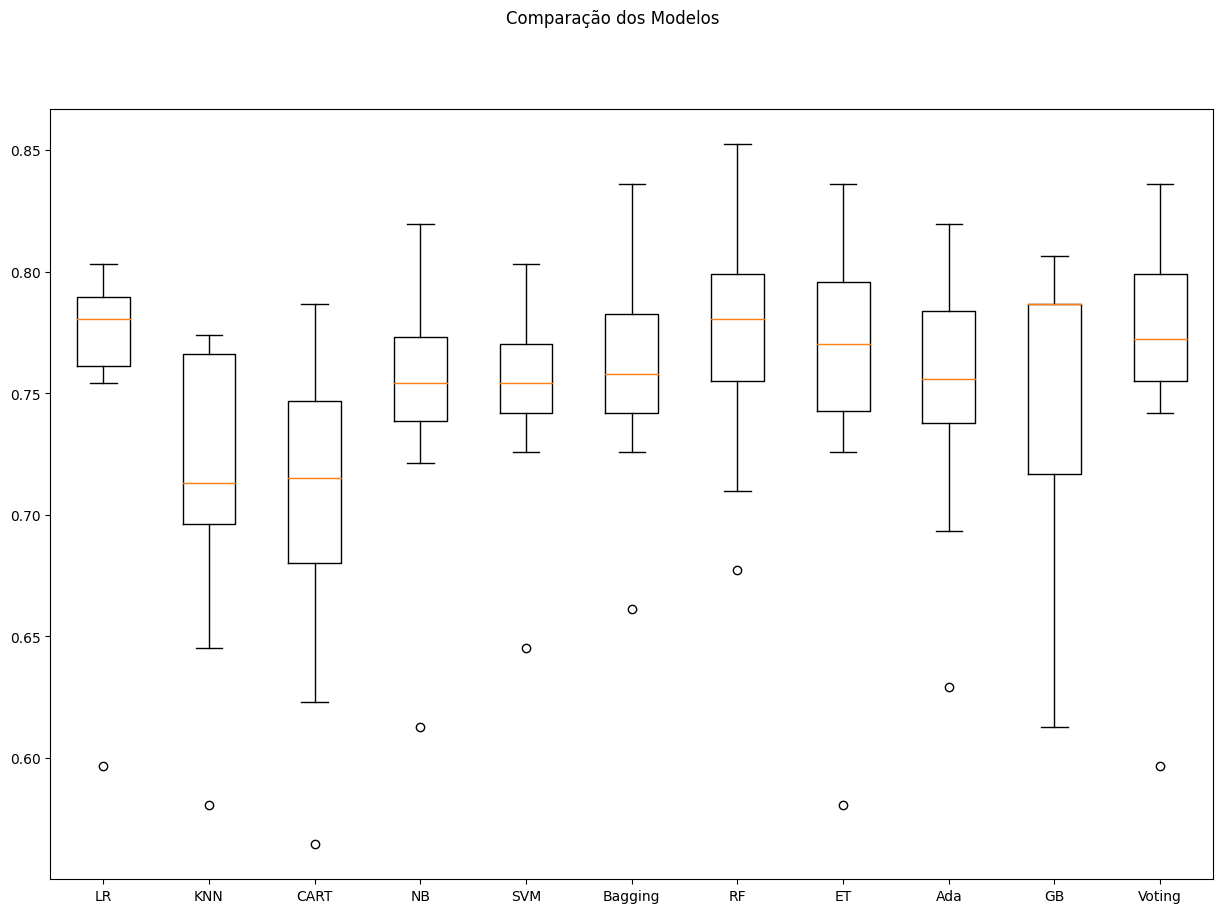

In [20]:
# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###Criação e avaliação de modelos: dados padronizados e normalizados

Em seguida, vamos repetir esse processo, utilizando a biblioteca Pipeline para criar e avaliar os modelos através da validação cruzada com os dados padronizados e normalizados (evitando o data leakage) e comparar o seu resultado com os modelos treinados com o dataset original:

In [21]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

In [22]:
# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

LR-orig: 0.762 (0.057)
KNN-orig: 0.712 (0.059)
CART-orig: 0.702 (0.063)
NB-orig: 0.746 (0.051)
SVM-orig: 0.749 (0.041)
Bag-orig: 0.761 (0.047)
RF-orig: 0.772 (0.048)
ET-orig: 0.756 (0.066)
Ada-orig: 0.749 (0.053)
GB-orig: 0.751 (0.057)
Vot-orig: 0.763 (0.061)
LR-padr: 0.762 (0.057)
KNN-padr: 0.727 (0.069)
CART-padr: 0.699 (0.048)
NB-padr: 0.746 (0.051)
SVM-padr: 0.763 (0.053)
Bag-padr: 0.772 (0.045)
RF-padr: 0.751 (0.048)
ET-padr: 0.776 (0.061)
Ada-padr: 0.749 (0.053)
GB-padr: 0.748 (0.058)
Vot-padr: 0.774 (0.047)
LR-norm: 0.751 (0.045)
KNN-norm: 0.725 (0.083)
CART-norm: 0.697 (0.069)
NB-norm: 0.746 (0.051)
SVM-norm: 0.772 (0.054)
Bag-norm: 0.766 (0.050)
RF-norm: 0.776 (0.043)
ET-norm: 0.767 (0.059)
Ada-norm: 0.749 (0.053)
GB-norm: 0.749 (0.058)
Vot-norm: 0.774 (0.049)


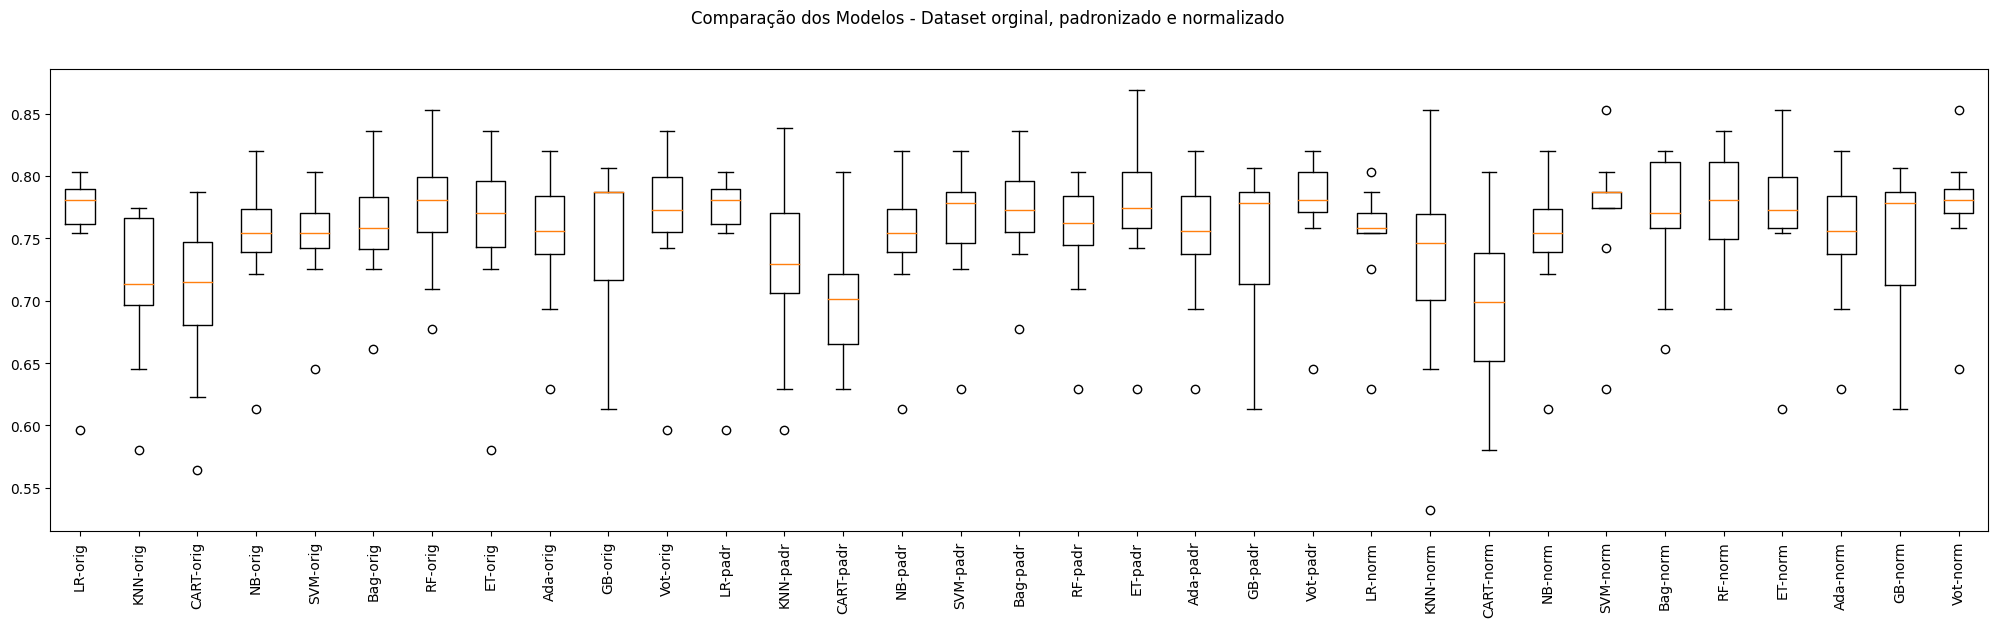

In [23]:
# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

###Otimização dos hiperparâmetros

Agora iremos utilizar a biblioteca Grid Search para executar a otimização dos hiperparâmetros do algoritmo KNN, a título de exemplificação, a fim de buscar resultados ainda melhores. Para tal, tentaremos todos os valores ímpares de k entre 1 e 21 e diferentes métricas de distância.

In [24]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.757615 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17}
Sem tratamento de missings: knn-padr - Melhor: 0.757509 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Sem tratamento de missings: knn-norm - Melhor: 0.759228 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 13}


##Finalização do Modelo

Podemos agora finalizar o modelo escolhido. Apenas para exemplificar, suponha que o modelo que alcançou os melhores resultados e foi o escolhido para implementação foi a regressão logística com os dados padronizados. A seguir, finalizaremos esse modelo, treinando-o em todo o conjunto de dados de treinamento (sem validação cruzada), e faremos predições para o conjunto de dados de teste que foi separado logo no início da prática, a fim de confirmarmos os resultados. Primeiro, iremos realizar a padronização dos dados de entrada. Depois, treinaremos o modelo e exibiremos a acurácia de teste.

In [25]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.7727272727272727


Por meio do conjunto de teste, verificamos que alcançamos acurácia de 77,27% em dados não vistos. Esse resultado foi ainda melhor do que a nossa avaliação anterior da regressão logística, que alcançou acurácia média de 76,2%. Valores semelhantes à acurácia de teste são esperados quando esse modelo estiver executando em produção e fazendo predições para novos dados.


Vamos agora preparar o modelo para utilização em produção. Para isso, vamos treiná-lo com todo o dataset, e não apenas o conjunto de treino.

In [26]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

LogisticRegression(max_iter=200)

##Simulando a aplicação do modelo em dados não vistos

Finalmente, iremos simular a aplicação do modelo em dados não vistos, imaginando que chegaram três novas instâncias, mas que não sabemos a classe de saída. Poderemos, então, aplicar nosso modelo recém-treinado para fazer a predição das classes. Para tal, será necessário antes padronizar os dados utilizando a mesma escala dos dados usados no treinamento do modelo:

In [27]:
# Novos dados - não sabemos a classe!
data = {'preg':  [1, 9, 5],
        'plas': [90, 100, 110],
        'pres': [50, 60, 50],
        'skin': [30, 30, 30],
        'test': [100, 100, 100],
        'mass': [20.0, 30.0, 40.0],
        'pedi': [1.0, 2.0, 1.0],
        'age': [15, 40, 40],
        }

atributos = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-0.84488505 -0.96691063 -0.98770975  0.59362962  0.17539902 -1.52208897
   1.59499624 -1.55207596]
 [ 1.53084665 -0.65393918 -0.47073225  0.59362962  0.17539902 -0.25289651
   4.61511492  0.57511787]
 [ 0.3429808  -0.34096773 -0.98770975  0.59362962  0.17539902  1.01629594
   1.59499624  0.57511787]]


##Conclusão

Podemos agora realizar a predição das classes para os novos dados:

In [28]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 1. 1.]
